In [82]:
### Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, medfilt

In [83]:
### Load datasets
optical_data = pd.read_csv("distance-sequence-1.csv")
servo_data = pd.read_csv("distance-sequence-servo-output-1.csv")
print(optical_data)

       Item1.Item1.X  Item1.Item1.Y  Item1.Item1.Brightness  Item1.Item2  \
0                  0              0                      93  2098.740032   
1                  0              0                      90  2098.750016   
2                  0              0                      91  2098.760032   
3                  0              0                      89  2098.770016   
4                  0              0                      91  2098.780032   
...              ...            ...                     ...          ...   
51045              0              0                     109  2609.190016   
51046              0              0                     100  2609.200032   
51047              0              0                     105  2609.210016   
51048              0              0                     103  2609.220032   
51049              0              0                     104  2609.230016   

             Item2  
0      3677.573984  
1      3677.584000  
2      3677.593984  
3  

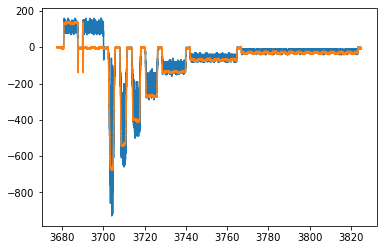

In [113]:
### Preview visualisation
time_range = (3500, 3825)

optical_motion = optical_data["Item1.Item1.X"]
optical_timebase = optical_data["Item2"]
servo_motion = servo_data["Item1"] - servo_data["Item1"][0] # Normalize to servo analog offset
servo_timebase = servo_data["Item2"]

optical_preview_index = np.where((optical_timebase >= time_range[0]) & (optical_timebase <= time_range[1]))[0]
servo_preview_index = np.where((servo_timebase >= time_range[0]) & (servo_timebase <= time_range[1]))[0]

plt.figure()
plt.plot(optical_timebase[optical_preview_index], optical_motion[optical_preview_index] * 10)
plt.plot(servo_timebase[servo_preview_index], -servo_motion[servo_preview_index])

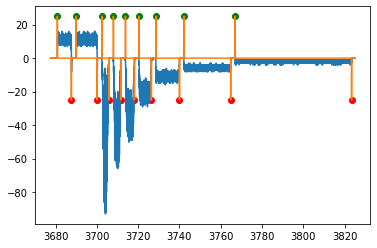

In [114]:
### Extract trial epochs
optical_diff = np.diff(optical_motion)

# Signal envelope
filtered_optical = filtered = np.abs(medfilt(optical_motion, 101))
filtered_optical[filtered_optical < 2] = 0
filtered_optical[filtered_optical > 0] = 25
on_signal = np.diff(filtered)
on_times = find_peaks(on_signal, height=1)[0]
off_times = find_peaks(-on_signal, height=1)[0]

# Plot preview trial extraction
plt.figure()
plt.plot(optical_timebase[optical_preview_index], optical_motion[optical_preview_index])
plt.plot(optical_timebase[optical_preview_index], on_signal[optical_preview_index])

preview_on_times = on_times[(on_times >= optical_preview_index[0]) & (on_times <= optical_preview_index[-1])]
preview_off_times = off_times[(off_times >= optical_preview_index[0]) & (off_times <= optical_preview_index[-1])]

plt.scatter(optical_timebase[preview_on_times], np.ones(len(optical_timebase[preview_on_times])) * 25, c='g')
plt.scatter(optical_timebase[preview_off_times], np.ones(len(optical_timebase[preview_off_times])) * -25, c='r')

In [115]:
### Organise by trial, 0 represents homing trials
# trial types for 1 experiment
distances = np.array([0, 0, 400, 400, 400, 400, 400, 400, 400, 200, 200, 200, 200, 200, 200, 200, 100, 100, 100, 100, 100, 100, 100, -400, -400, -400, -400, -400, -400, -400, -200, -200, -200, -200, -200, -200, -200, -100, -100, -100, -100, -100, -100, -100])
velocities = np.array([0, 0, 250, 200, 150, 100, 50,  25,  10,  250, 200, 150, 100, 50,  25,  10,  250, 200, 150, 100, 50,  25,  10, 250, 200, 150, 100, 50,  25,  10,  250, 200, 150, 100, 50,  25,  10,  250, 200, 150, 100, 50,  25,  10 ])

# Exclude homing trials
homing_on_times = on_times[velocities == 0]
homing_off_times = off_times[velocities == 0]

trial_on_times = on_times[velocities > 0]
trial_off_times = off_times[velocities > 0]
distances = distances[velocities > 0]
velocities = velocities[velocities > 0]

# check trial matching
assert len(trial_on_times) == len(trial_off_times), "Mismatch trial times"
assert len(trial_on_times) == len(distances) == len(velocities), "Mismatch trial number"

0.0063279696257457965


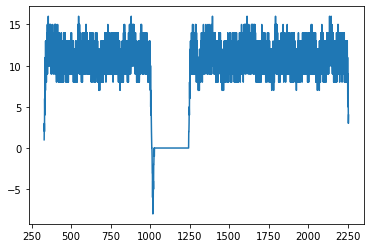

In [116]:
### Estimate true distance from homing trials
homing_distance_cm = 70

plt.figure()
plt.plot(optical_motion[homing_on_times[0]:homing_off_times[-1]])

homing_distance_integral = list()
for index in range(len(homing_on_times)):
    signal_period = np.array(optical_motion[homing_on_times[index]:homing_off_times[index]])
    homing_distance_integral.append(np.sum(signal_period))

distance_coeff = homing_distance_cm / homing_distance_integral[1]
print(distance_coeff)

Text(0, 0.5, 'Optical distance (cm)')

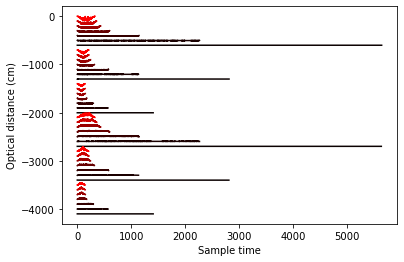

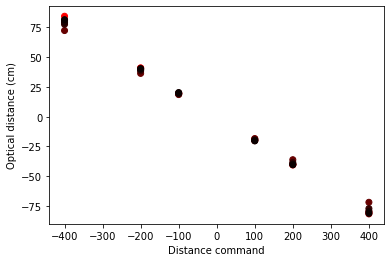

In [117]:
### Stats for each trial + sanity check plot
distance_integral = list()
cmap = list(map(lambda v: (v / np.max(velocities), 0, 0), velocities))

plt.figure()
for t_index in range(len(trial_on_times)):
    signal_period = np.array(optical_motion[trial_on_times[t_index]:trial_off_times[t_index]])
    distance_integral.append(np.sum(signal_period) * distance_coeff)
    plt.plot(signal_period + (t_index*-100), c=cmap[t_index])
plt.xlabel("Sample time")
plt.ylabel("Optical distance (cm)")

distance_integral = np.array(distance_integral)

plt.figure()
plt.scatter(distances, distance_integral, c=cmap)
plt.xlabel("Distance command")
plt.ylabel("Optical distance (cm)")

In [118]:
### Position error across all trials
for d in np.unique(distances):
    mean_at_d = np.mean(distance_integral[distances == d])
    std_at_d = np.std(distance_integral[distances == d])
    print(d, mean_at_d, std_at_d, std_at_d / mean_at_d)

-400 79.48020249502801 3.4960077755615613 0.04398589417006403
-200 39.495570421261974 1.4890424880239719 0.037701506071231815
-100 19.455794612185862 0.4987566163129177 0.02563537631100035
100 -19.487434460314592 0.6884483399488724 -0.0353278078420672
200 -39.336467184957506 1.458553226983105 -0.03707890747089927
400 -78.83474959320196 3.150125909686182 -0.03995859599911537


(array([1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 2., 1., 3., 0., 1., 2., 1.,
        1., 2., 1., 2., 1., 2., 0., 4., 1., 1., 1., 1., 2., 3., 2., 1., 0.,
        0., 1., 1., 0., 0., 1.]),
 array([-0.030016, -0.02804 , -0.026064, -0.024088, -0.022112, -0.020136,
        -0.01816 , -0.016184, -0.014208, -0.012232, -0.010256, -0.00828 ,
        -0.006304, -0.004328, -0.002352, -0.000376,  0.0016  ,  0.003576,
         0.005552,  0.007528,  0.009504,  0.01148 ,  0.013456,  0.015432,
         0.017408,  0.019384,  0.02136 ,  0.023336,  0.025312,  0.027288,
         0.029264,  0.03124 ,  0.033216,  0.035192,  0.037168,  0.039144,
         0.04112 ,  0.043096,  0.045072,  0.047048,  0.049024]),
 <BarContainer object of 40 artists>)

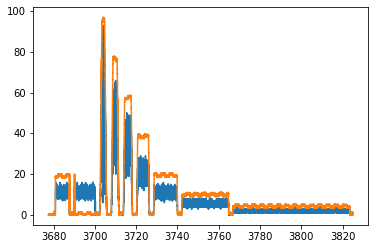

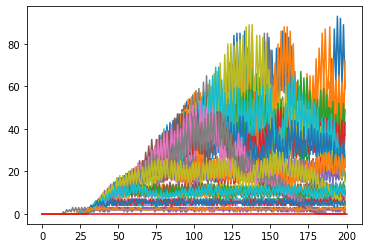

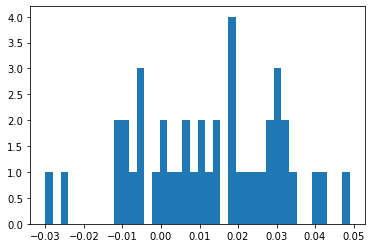

In [168]:
### Latencies between optical measurement and servo feedback
plt.figure()
plt.plot(optical_timebase[optical_preview_index], np.abs(optical_motion[optical_preview_index]))
plt.plot(servo_timebase[servo_preview_index], np.abs(servo_motion[servo_preview_index]) / 7)

# get baselines for optical and servo recordings
# optical_baseline = np.mean(optical_motion[np.abs(optical_motion) < 3]) + np.std(optical_motion[np.abs(optical_motion) < 3]) * 3
optical_baseline = 0
servo_baseline = np.mean(servo_motion[np.abs(servo_motion) < 10]) + np.std(servo_motion[np.abs(servo_motion) < 10]) * 3

# get ramps for optical and servo trial starts
optical_start_times = optical_timebase[trial_on_times] - 0.3

time_diffs = list()

plt.figure()
window = 200
for t in optical_start_times:
    os = np.where(optical_timebase >= t)[0][0] # what time did this optical event start?
    os_t = optical_timebase[os]
    ss = np.where(servo_timebase >= t)[0][0] # what time did the matching servo event start?
    ss_t = servo_timebase[ss]

    # what was the first time that this optical event exceeded baseline?
    optical_rise_time = np.array(optical_timebase[(optical_timebase > os_t) & (np.abs(optical_motion) > optical_baseline)])[0] - os_t

    # what was the first time that this servo event exceeded baseline?
    servo_rise_time = np.array(servo_timebase[(servo_timebase > ss_t) & (np.abs(servo_motion) > servo_baseline)])[0] - ss_t

    time_diffs.append(optical_rise_time - servo_rise_time)

    optical_rise = np.array(np.abs(optical_motion[os:(os+window)]))
    servo_rise = np.array(np.abs(servo_motion[ss:(ss+window)]))

    plt.plot(optical_rise)

plt.plot([0, window], [optical_baseline, optical_baseline], 'r')

plt.figure()
plt.hist(np.array(time_diffs), 40)